In [46]:
pip install scikit-learn pandas numpy matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [47]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnull, when
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("CustomerSegmentation") \
    .getOrCreate()

In [48]:
# Load data into Spark DataFrame
cus_df = spark.read.csv("ctzn_customer_segmentation_data.csv", header=True, inferSchema=True)
cus_df.show(5)

+----------+---------+------------------+-----------------+----------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+---------+------+----------------+----------------+------------+
|    cif_id|schm_type|           balance|balance_frequency| purchases|oneoff_purchases|installments_purchases|cash_advance|purchases_frequency|oneoff_purchases_frequency|purchases_installments_frequency|cash_advance_frequency|cash_advance_trx|purchases_trx| payments|tenure|minimum_payments|prc_full_payment|credit_limit|
+----------+---------+------------------+-----------------+----------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+---------+------+----------------+----------------+------------+
|C000000020|      CAA|-41754.05000

In [49]:
# Show the schema and basic info
cus_df.printSchema()

root
 |-- cif_id: string (nullable = true)
 |-- schm_type: string (nullable = true)
 |-- balance: double (nullable = true)
 |-- balance_frequency: integer (nullable = true)
 |-- purchases: double (nullable = true)
 |-- oneoff_purchases: double (nullable = true)
 |-- installments_purchases: double (nullable = true)
 |-- cash_advance: double (nullable = true)
 |-- purchases_frequency: integer (nullable = true)
 |-- oneoff_purchases_frequency: integer (nullable = true)
 |-- purchases_installments_frequency: integer (nullable = true)
 |-- cash_advance_frequency: integer (nullable = true)
 |-- cash_advance_trx: integer (nullable = true)
 |-- purchases_trx: integer (nullable = true)
 |-- payments: double (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- minimum_payments: double (nullable = true)
 |-- prc_full_payment: integer (nullable = true)
 |-- credit_limit: double (nullable = true)



In [50]:
# Show basic summary statistics
cus_df.describe().show()

+-------+----------+---------+------------------+-----------------+--------------------+--------------------+----------------------+--------------------+-------------------+--------------------------+--------------------------------+----------------------+------------------+------------------+--------------------+-----------------+------------------+-------------------+--------------------+
|summary|    cif_id|schm_type|           balance|balance_frequency|           purchases|    oneoff_purchases|installments_purchases|        cash_advance|purchases_frequency|oneoff_purchases_frequency|purchases_installments_frequency|cash_advance_frequency|  cash_advance_trx|     purchases_trx|            payments|           tenure|  minimum_payments|   prc_full_payment|        credit_limit|
+-------+----------+---------+------------------+-----------------+--------------------+--------------------+----------------------+--------------------+-------------------+--------------------------+------------

# 1. Data Analysis
### 1.1 Minimum and Maximum amount in Balance Attribute

In [51]:
from pyspark.sql.functions import max, min, avg

# Maximum, minimum, and mean values for 'balance'
cus_df.select(
    max(col('balance')).alias('max_balance'),
    min(col('balance')).alias('min_balance'),
    avg(col('balance')).alias('mean_balance')
).show()


+-----------+----------------+------------------+
|max_balance|     min_balance|      mean_balance|
+-----------+----------------+------------------+
|      4.4E9|-2.81020310583E9|2163.3194175555564|
+-----------+----------------+------------------+



In [52]:
cus_df_pd.describe().T

,count,mean,std,min,25%,50%,75%,max
balance,1182731.0,5.904476e+00,1.113970e+01,-39.64,0.02,1.10,7.5900,6.607000e+01
balance_frequency,1943721.0,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.0000,0.000000e+00
purchases,1943721.0,2.490123e+06,1.792584e+08,0.00,0.05,0.66,6115.4700,6.588771e+10
oneoff_purchases,1943721.0,6.813420e+05,3.878347e+07,0.00,0.05,0.66,5065.0000,1.199091e+10
installments_purchases,1943721.0,1.808781e+06,1.430306e+08,0.00,0.00,0.00,0.2800,5.761043e+10
cash_advance,1943721.0,1.601158e+05,5.210609e+07,0.00,0.00,0.00,0.0000,5.677367e+10
purchases_frequency,1943721.0,2.664435e+00,1.220735e+01,0.00,1.00,1.00,2.0000,8.117000e+03
oneoff_purchases_frequency,1943721.0,9.388693e-03,9.643936e-02,0.00,0.00,0.00,0.0000,1.000000e+00
purchases_installments_frequency,1943721.0,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.0000,0.000000e+00
cash_advance_frequency,1943721.0,7.625158e-01,4.255415e-01,0.00,1.00,1.00,1.0000,1.000000e+00


In [53]:
# creditcard_df[creditcard_df['ONEOFF_PURCHASES'] == 40761.250000]

cus_df_pd[cus_df_pd['oneoff_purchases'] == 579037.54 ]

,cif_id,schm_type,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,payments,tenure,minimum_payments,prc_full_payment,credit_limit


In [54]:
cus_df_pd['cash_advance'].max()

np.float64(56773670310.15998)

# 1.2 VISUALIZING AND EXPLORING THE DATASET

+------+---------+-------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+--------+------+----------------+----------------+------------+
|cif_id|schm_type|balance|balance_frequency|purchases|oneoff_purchases|installments_purchases|cash_advance|purchases_frequency|oneoff_purchases_frequency|purchases_installments_frequency|cash_advance_frequency|cash_advance_trx|purchases_trx|payments|tenure|minimum_payments|prc_full_payment|credit_limit|
+------+---------+-------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+--------+------+----------------+----------------+------------+
|     0|        0|      0|                0|        0|               0|              

/tmp/ipykernel_24300/2302443162.py:14: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_data_pd.columns, y=missing_data_pd.iloc[0], palette='Blues')


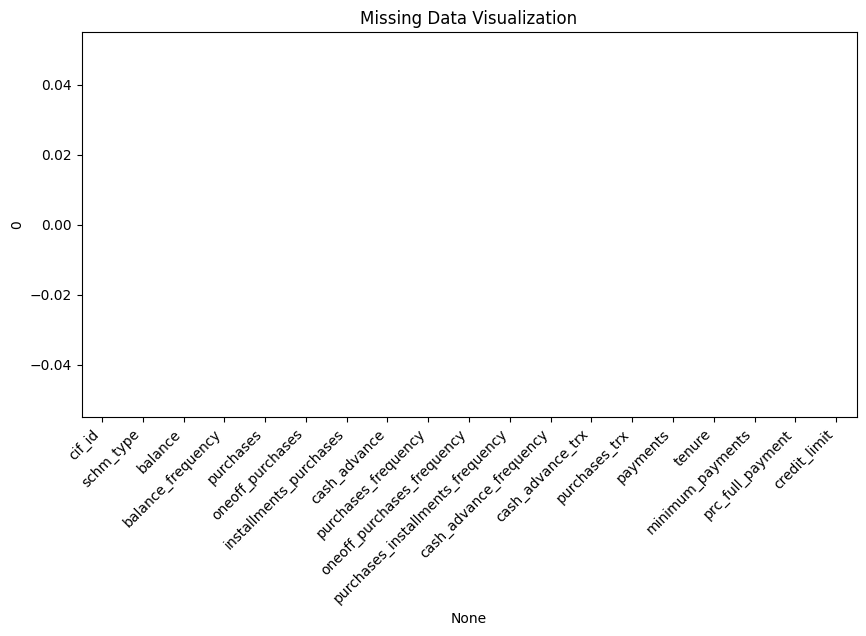

In [55]:
from pyspark.sql.functions import col, isnull, sum

# Count the number of missing values in each column
missing_data = cus_df.select([isnull(col(column)).cast("int").alias(column) for column in cus_df.columns])

# Sum up the missing values for each column
missing_data_sum = missing_data.select([sum(col(column)).alias(column) for column in cus_df.columns])

missing_data_sum.show()

# Plotting missing values (using Pandas for plotting)
missing_data_pd = missing_data_sum.toPandas()
plt.figure(figsize=(10, 5))
sns.barplot(x=missing_data_pd.columns, y=missing_data_pd.iloc[0], palette='Blues')
plt.xticks(rotation=45, ha='right')
plt.title('Missing Data Visualization')
plt.show()


In [56]:
# Replace missing 'credit_limit' with the mean value
mean_credit_limit = cus_df.agg({'credit_limit': 'avg'}).collect()[0][0]
cus_df = cus_df.fillna({'credit_limit': mean_credit_limit})

In [58]:
# cus_df[cus_df['purchases_installments_frequency'].isnull() == True]

# Credit Limit

In [60]:
# ## Replacing "Credit Limit" With Mean value
# cus_df_pd.loc[(cus_df['credit_limit'].isnull() == True), 'credit_limit'] = cus_df['credit_limit'].mean()

In [61]:
cus_df_pd.isnull().sum()

cif_id                                   0
schm_type                                0
balance                             760990
balance_frequency                        0
purchases                                0
oneoff_purchases                         0
installments_purchases                   0
cash_advance                             0
purchases_frequency                      0
oneoff_purchases_frequency               0
purchases_installments_frequency         0
cash_advance_frequency                   0
cash_advance_trx                         0
purchases_trx                            0
payments                                 0
tenure                                   0
minimum_payments                         0
prc_full_payment                         0
credit_limit                             0
dtype: int64

## Check for outliers:
Using IQR, we can follow the below approach to find outliers:

* Calculate the first and third quartile (Q1 and Q3).
* Further, evaluate the interquartile range, IQR = Q3-Q1.
* Estimate the lower bound, the lower bound = Q11.5
* Estimate the upper bound, upper bound = Q31.5
* The data points that lie outside of the lower and the upper bound are outliers.

In [62]:
def handle_outliers(df, column):
    # Calculate IQR
    Q1 = df.approxQuantile(column, [0.25], 0.05)[0]
    Q3 = df.approxQuantile(column, [0.75], 0.05)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    
    # Replace outliers with null
    df = df.withColumn(column, when((col(column) < lower_bound) | (col(column) > upper_bound), None).otherwise(col(column)))
    return df

# Handle outliers for a specific column
cus_df = handle_outliers(cus_df, 'balance')


In [63]:
from pyspark.sql.types import IntegerType, FloatType

# Filter only numeric columns (IntegerType or FloatType)
numeric_columns = [col for col, dtype in cus_df.dtypes if dtype in ['int', 'bigint', 'double', 'float']]

# Print the numeric columns to verify
print("Numeric columns:", numeric_columns)

# Apply the Imputer if there are numeric columns
if numeric_columns:
    imputer = Imputer(inputCols=numeric_columns, outputCols=[col + "_imputed" for col in numeric_columns])
    cus_df_imputed = imputer.fit(cus_df).transform(cus_df)
    cus_df_imputed.show(5)
else:
    print("No numeric columns found for imputation.")


Numeric columns: ['balance', 'balance_frequency', 'purchases', 'oneoff_purchases', 'installments_purchases', 'cash_advance', 'purchases_frequency', 'oneoff_purchases_frequency', 'purchases_installments_frequency', 'cash_advance_frequency', 'cash_advance_trx', 'purchases_trx', 'payments', 'tenure', 'minimum_payments', 'prc_full_payment', 'credit_limit']


+----------+---------+-------+-----------------+----------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+---------+------+----------------+----------------+------------+---------------+-------------------------+-----------------+------------------------+------------------------------+--------------------+---------------------------+----------------------------------+----------------------------------------+------------------------------+------------------------+---------------------+----------------+--------------+------------------------+------------------------+--------------------+
|    cif_id|schm_type|balance|balance_frequency| purchases|oneoff_purchases|installments_purchases|cash_advance|purchases_frequency|oneoff_purchases_frequency|purchases_installments_frequency|cash_advance_frequency|cash_advance_trx|purchases_trx| payments|tenure|mini

In [64]:
# Count duplicate records
cus_df.count() - cus_df.distinct().count()


25/03/20 04:39:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/20 04:39:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/20 04:40:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/20 04:40:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/20 04:40:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/20 04:40:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


0

## Removing Outliers
Let's get rid of the noise. First set all outliers as NaN, so it will be taken care of in the next stage, where I impute the missing values.

In [70]:
# Select only numeric columns (ignore categorical data like customer IDs)
non_categorical_data = raw_df.select([col for col, dtype in raw_df.dtypes if dtype in ['int', 'double']])


In [72]:
# for column in non_categorical_data.columns:
#     data = non_categorical_data[column]
    
#     Q1 = data.quantile(0.25)
#     Q3 = data.quantile(0.75)
#     IQR = Q3 - Q1
#     minimum = Q1 - (1.5 * IQR)
#     maximum = Q3 + (1.5 * IQR)
 
#     outliers = ((data < minimum) | (data > maximum))
#     non_categorical_data[column].loc[outliers] = np.nan
    
# non_categorical_data.isna().sum()

# Imputing the missing data - KNN Imputer
I use KNN imputer: Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set.

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.impute import KNNImputer

# # Convert all columns to numeric (forcing errors='coerce' to handle unexpected types)
# numeric_data = non_categorical_data.apply(pd.to_numeric, errors='coerce')

# # Drop columns that are completely NaN before applying KNNImputer
# numeric_data = numeric_data.dropna(axis=1, how='all')

# # Check the new column count
# print(f"Columns before imputation: {numeric_data.shape[1]}")

# # Apply KNN imputation
# imputer = KNNImputer()
# imputed_array = imputer.fit_transform(numeric_data)

# # Convert back to DataFrame with correct column names
# imp_data = pd.DataFrame(imputed_array, columns=numeric_data.columns)

# # Check for remaining NaN values
# print("Remaining missing values after imputation:")
# print(imp_data.isna().sum())



Columns before imputation: 17


In [73]:
# # Duplicated value

# cus_df.duplicated().sum()

# 2. Data Visualization -

We will visualise the data, to find hidden patterns or trends.

### 2.1 Distplot

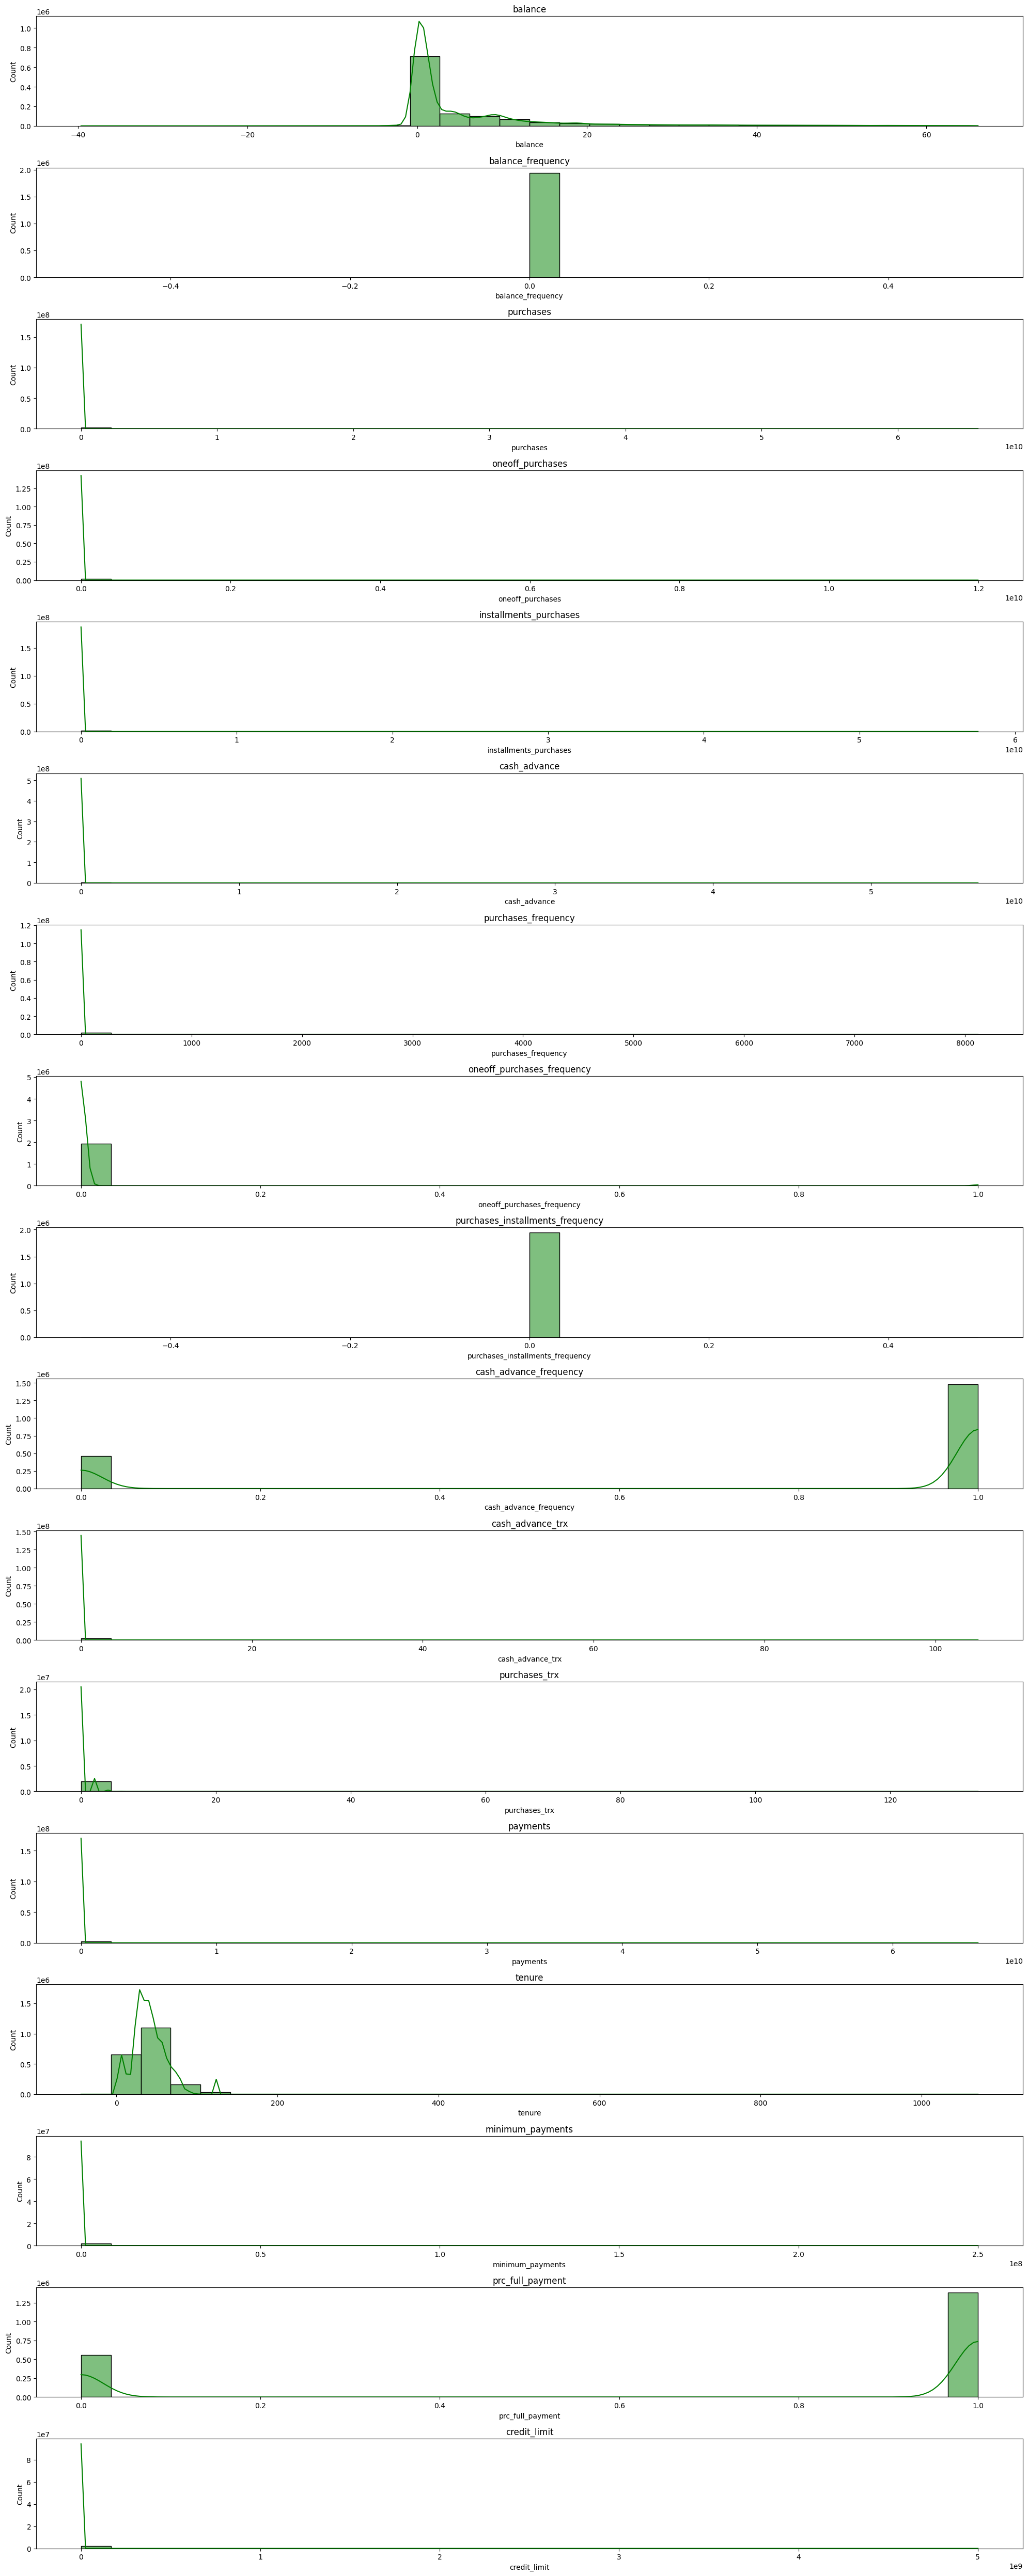

In [74]:
# Collect the data to Pandas and plot distributions
cus_df_pd = cus_df.toPandas()

# Select only numeric columns for plotting
numeric_columns = cus_df_pd.select_dtypes(include=['number']).columns.tolist()

plt.figure(figsize=(20, 50))
for i, column in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns), 1, i + 1)
    sns.histplot(cus_df_pd[column], kde=True, color="g", bins=30)  # You can use distplot if you like
    plt.title(column)

plt.tight_layout()
plt.show()


# Heat map for correlation analysis `

25/03/20 04:56:37 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


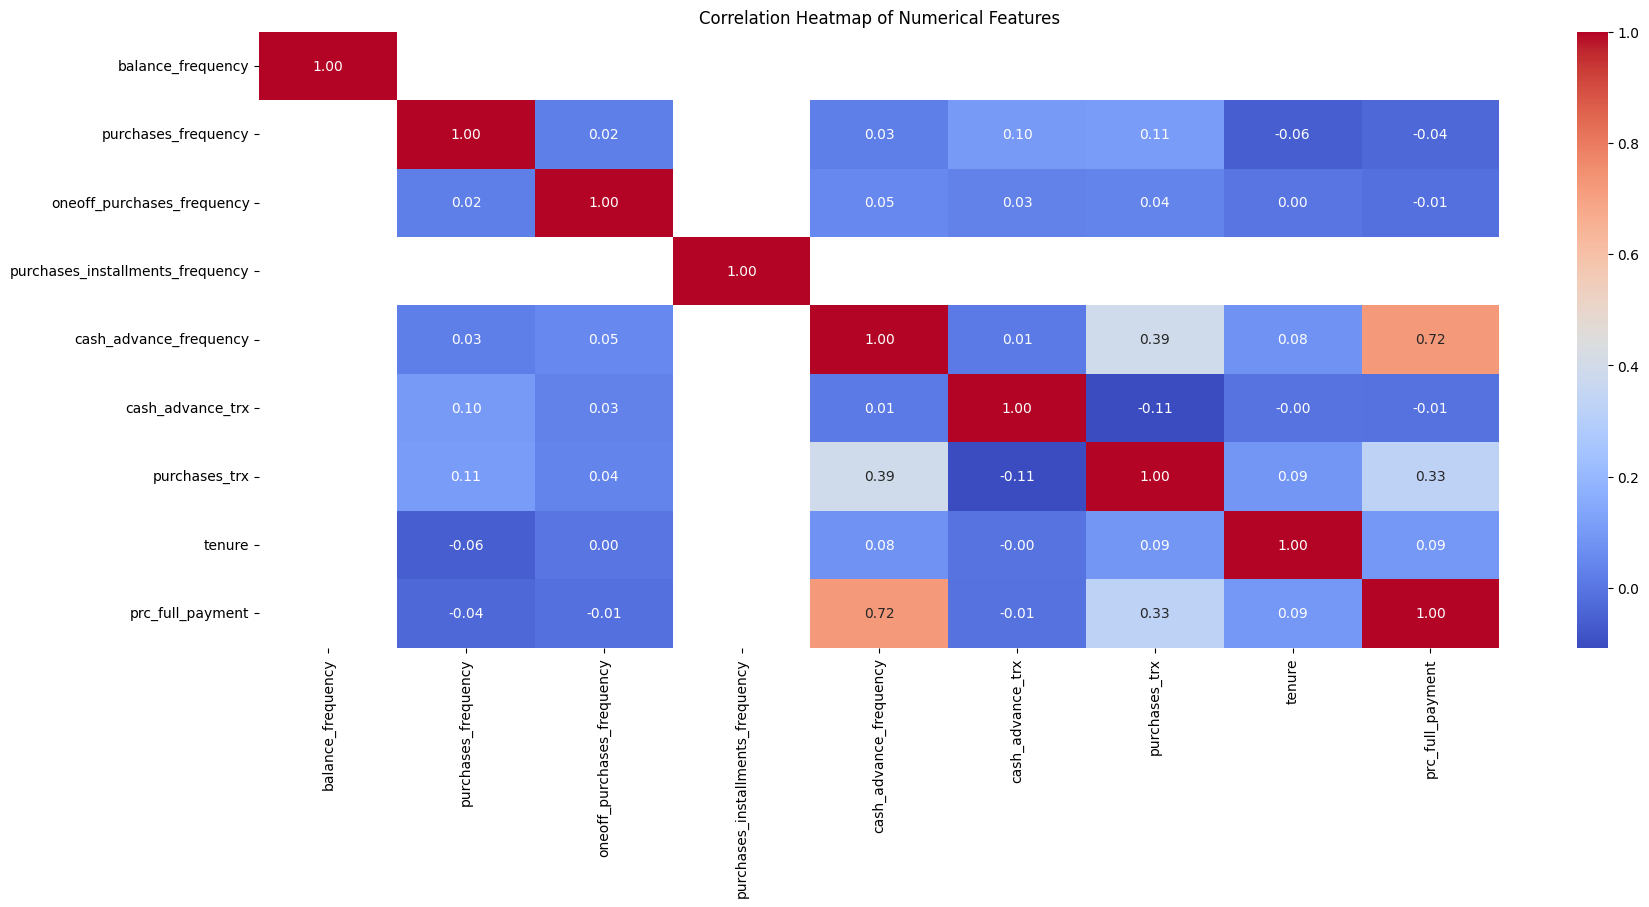

In [75]:
# Select numeric columns
numeric_columns = [col for col in cus_df.columns if isinstance(cus_df.schema[col].dataType, (IntegerType, FloatType))]

# Assemble the features into a vector
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
cus_df_assembled = assembler.transform(cus_df)

# Compute the correlation matrix
pearson_corr = Correlation.corr(cus_df_assembled, 'features').head()[0]

# Convert the correlation matrix to Pandas and plot
import pandas as pd
corr_matrix = pd.DataFrame(pearson_corr.toArray(), columns=numeric_columns, index=numeric_columns)

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


# Feature Engineering 

In [76]:
from pyspark.sql import functions as F

# Feature Engineering (similar to your Pandas code)
cus_df = cus_df.withColumn("new_balance_balance_frequency", cus_df["balance"] * cus_df["balance_frequency"]) \
    .withColumn("new_oneoff_purchases_purchases", cus_df["oneoff_purchases"] / cus_df["purchases"]) \
    .withColumn("new_installments_purchases_purchases", cus_df["installments_purchases"] / cus_df["purchases"]) \
    .withColumn("new_cash_advance_purchases_purchases", cus_df["cash_advance"] * cus_df["cash_advance_frequency"]) \
    .withColumn("new_purchases_purchases_frequency", cus_df["purchases"] * cus_df["purchases_frequency"]) \
    .withColumn("new_purchases_oneoff_purchases_frequency", cus_df["purchases"] * cus_df["oneoff_purchases_frequency"]) \
    .withColumn("new_purchases_purchases_trx", cus_df["purchases"] / cus_df["purchases_trx"]) \
    .withColumn("new_cash_advance_cash_advance_trx", cus_df["cash_advance"] / cus_df["cash_advance_trx"]) \
    .withColumn("new_balance_credit_limit", cus_df["balance"] / cus_df["credit_limit"]) \
    .withColumn("new_payments_credit_limit", cus_df["payments"] / cus_df["minimum_payments"])

# Check for missing values
cus_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in cus_df.columns]).show()

# Replace missing values with 0
cus_df = cus_df.fillna(0)

# Verify missing values again
cus_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in cus_df.columns]).show()

# Set index (although Spark DataFrame does not have a direct index, you can use 'cif_id' as a unique identifier)
# cus_df.createOrReplaceTempView("customer_data")


+------+---------+-------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+--------+------+----------------+----------------+------------+-----------------------------+------------------------------+------------------------------------+------------------------------------+---------------------------------+----------------------------------------+---------------------------+---------------------------------+------------------------+-------------------------+
|cif_id|schm_type|balance|balance_frequency|purchases|oneoff_purchases|installments_purchases|cash_advance|purchases_frequency|oneoff_purchases_frequency|purchases_installments_frequency|cash_advance_frequency|cash_advance_trx|purchases_trx|payments|tenure|minimum_payments|prc_full_payment|credit_limit|new_balance_balance_frequency|new_oneoff_purchases_purchases|new_ins

+------+---------+-------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+--------+------+----------------+----------------+------------+-----------------------------+------------------------------+------------------------------------+------------------------------------+---------------------------------+----------------------------------------+---------------------------+---------------------------------+------------------------+-------------------------+
|cif_id|schm_type|balance|balance_frequency|purchases|oneoff_purchases|installments_purchases|cash_advance|purchases_frequency|oneoff_purchases_frequency|purchases_installments_frequency|cash_advance_frequency|cash_advance_trx|purchases_trx|payments|tenure|minimum_payments|prc_full_payment|credit_limit|new_balance_balance_frequency|new_oneoff_purchases_purchases|new_ins

In [22]:
# # Checking missing 

# cus_df.isnull().sum().sort_values(ascending=False).head()
# # creditcard_df.isnull().sum().sort_values(ascending=False).head()

In [24]:
# cus_df.fillna(0, inplace=True)

In [25]:
# cus_df.isnull().sum().sort_values(ascending=False).head()

In [27]:
# #Indexing CUST_ID feature
# cus_df.set_index('cif_id', inplace=True)
# # cus_df.head()

In [77]:
def outlier_thresholds(df, variable):
    quantiles = df.approxQuantile(variable, [0.01, 0.99], 0.05)
    quartile1, quartile3 = quantiles[0], quantiles[1]
    IQR = quartile3 - quartile1
    low_limit = quartile1 - 1.5 * IQR
    up_limit = quartile3 + 1.5 * IQR
    return low_limit, up_limit

def replace_with_thresholds(df, variable):
    low_limit, up_limit = outlier_thresholds(df, variable)
    df = df.withColumn(variable, F.when(F.col(variable) < low_limit, low_limit).otherwise(F.col(variable)))
    df = df.withColumn(variable, F.when(F.col(variable) > up_limit, up_limit).otherwise(F.col(variable)))
    return df

# Apply outlier handling for each numeric column
numeric_columns = [field.name for field in cus_df.schema.fields if isinstance(field.dataType, (IntegerType, FloatType))]

for col_name in numeric_columns:
    cus_df = replace_with_thresholds(cus_df, col_name)


In [78]:
from pyspark.sql.types import IntegerType, FloatType, DoubleType, LongType, DecimalType

# First, print the schema to inspect column types
print("DataFrame Schema:")
cus_df.printSchema()

# Include all numeric types, not just Integer and Float
numeric_types = (IntegerType, FloatType, DoubleType, LongType, DecimalType)
numeric_columns = [col_name for col_name in cus_df.columns 
                  if isinstance(cus_df.schema[col_name].dataType, numeric_types)]

# Print the detected numeric columns
print(f"Detected numeric columns: {numeric_columns}")

# Only proceed if there are actually numeric columns
if not numeric_columns:
    print("No numeric columns found in the dataframe. Check your data types.")
else:
    # Assemble features into a single vector
    assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
    cus_df_assembled = assembler.transform(cus_df)
    
    # Apply Min-Max scaling
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    scaler_model = scaler.fit(cus_df_assembled)
    cus_df_scaled = scaler_model.transform(cus_df_assembled)
    
    # Select the scaled features and drop others
    cus_df_scaled = cus_df_scaled.select("scaled_features", "cif_id", *numeric_columns)
    
    # Show scaled data (first 5 rows)
    cus_df_scaled.show(5)

DataFrame Schema:
root
 |-- cif_id: string (nullable = true)
 |-- schm_type: string (nullable = true)
 |-- balance: double (nullable = false)
 |-- balance_frequency: double (nullable = true)
 |-- purchases: double (nullable = false)
 |-- oneoff_purchases: double (nullable = false)
 |-- installments_purchases: double (nullable = false)
 |-- cash_advance: double (nullable = false)
 |-- purchases_frequency: double (nullable = true)
 |-- oneoff_purchases_frequency: double (nullable = true)
 |-- purchases_installments_frequency: double (nullable = true)
 |-- cash_advance_frequency: double (nullable = true)
 |-- cash_advance_trx: double (nullable = true)
 |-- purchases_trx: double (nullable = true)
 |-- payments: double (nullable = false)
 |-- tenure: double (nullable = true)
 |-- minimum_payments: double (nullable = false)
 |-- prc_full_payment: double (nullable = true)
 |-- credit_limit: double (nullable = false)
 |-- new_balance_balance_frequency: double (nullable = false)
 |-- new_oneoff

+--------------------+----------+-------+-----------------+----------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+---------+------+----------------+----------------+------------+-----------------------------+------------------------------+------------------------------------+------------------------------------+---------------------------------+----------------------------------------+---------------------------+---------------------------------+------------------------+-------------------------+
|     scaled_features|    cif_id|balance|balance_frequency| purchases|oneoff_purchases|installments_purchases|cash_advance|purchases_frequency|oneoff_purchases_frequency|purchases_installments_frequency|cash_advance_frequency|cash_advance_trx|purchases_trx| payments|tenure|minimum_payments|prc_full_payment|credit_limit|new_balance_balance_frequency|new_

25/03/20 05:09:50 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


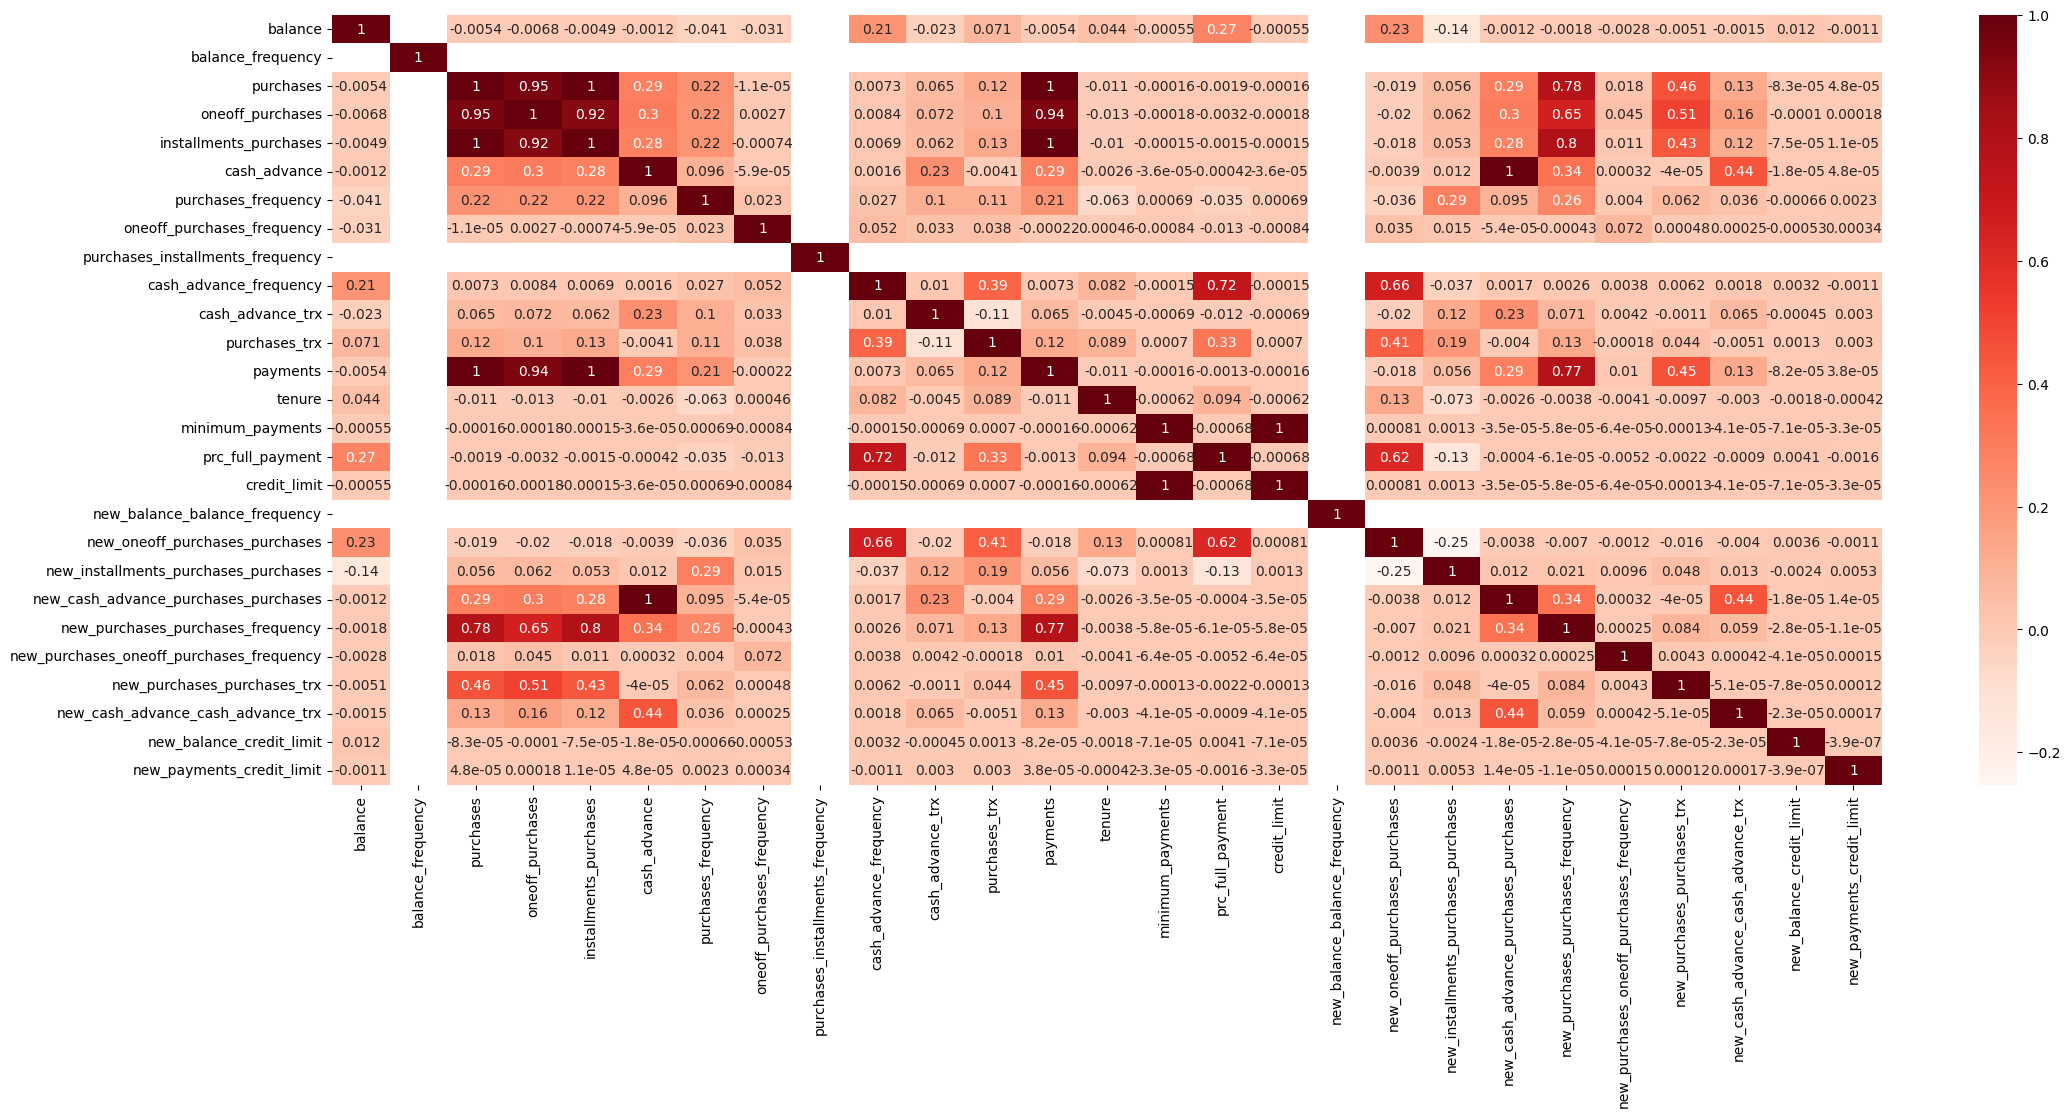

In [79]:
from pyspark.ml.stat import Correlation

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(cus_df_assembled, "features").head()[0]
correlation_matrix = correlation_matrix.toArray()

# Convert the correlation matrix to a Pandas DataFrame for visualization
import pandas as pd
correlation_df = pd.DataFrame(correlation_matrix, columns=numeric_columns, index=numeric_columns)

# Plot the heatmap of correlations
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 10))
sns.heatmap(correlation_df, annot=True, cmap="Reds")
plt.show()


25/03/20 05:10:09 WARN Instrumentation: [2f1c4db9] regParam is zero, which might cause numerical instability and overfitting.
25/03/20 05:10:19 WARN Instrumentation: [2f1c4db9] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


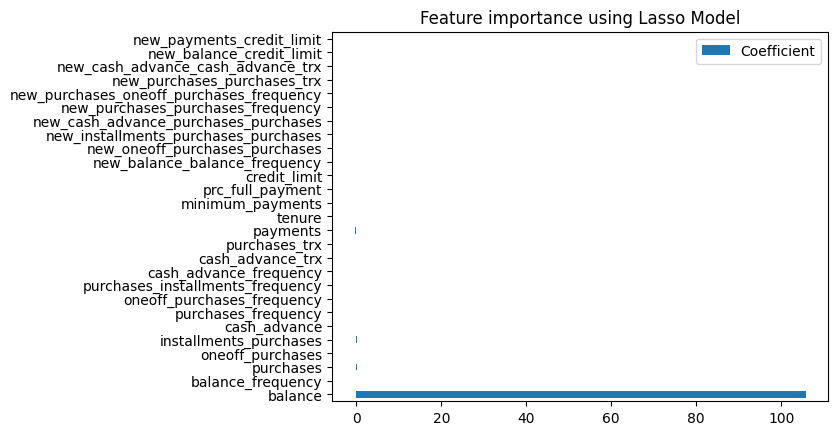

Best alpha: LinearRegression_229ae630acd9__elasticNetParam
Model R2 score: 0.9999999999831418


In [80]:
from pyspark.ml.regression import LinearRegression

# Prepare the data for Lasso regression
lasso = LinearRegression(featuresCol="scaled_features", labelCol="balance", elasticNetParam=1.0)

# Fit the model
lasso_model = lasso.fit(cus_df_scaled)

# Get the coefficients (feature importance)
coefficients = lasso_model.coefficients

# Show feature importance
feature_importance = pd.DataFrame(coefficients.toArray(), columns=["Coefficient"], index=numeric_columns)

# Plot feature importance
feature_importance.plot(kind="barh")
plt.title("Feature importance using Lasso Model")
plt.show()

# Print the best alpha and model score
print(f"Best alpha: {lasso_model.elasticNetParam}")
print(f"Model R2 score: {lasso_model.summary.r2}")


# LASSO CV Feature Importance


In [71]:
from sklearn.linear_model import LassoCV

# Corrected drop() method
X = data_scaled.drop(["balance", "new_balance_balance_frequency", "new_balance_credit_limit", "balance_frequency"], axis=1)   # Feature Matrix
y = data_scaled["balance"]  # Target Variable

# Lasso Regression Model
reg = LassoCV()
reg.fit(X, y)


LassoCV()

In [72]:

print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.000081
Best score using built-in LassoCV: 0.999511


In [73]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  
      str(sum(coef == 0)) + " variables")

Lasso picked 3 variables and eliminated the other 20 variables


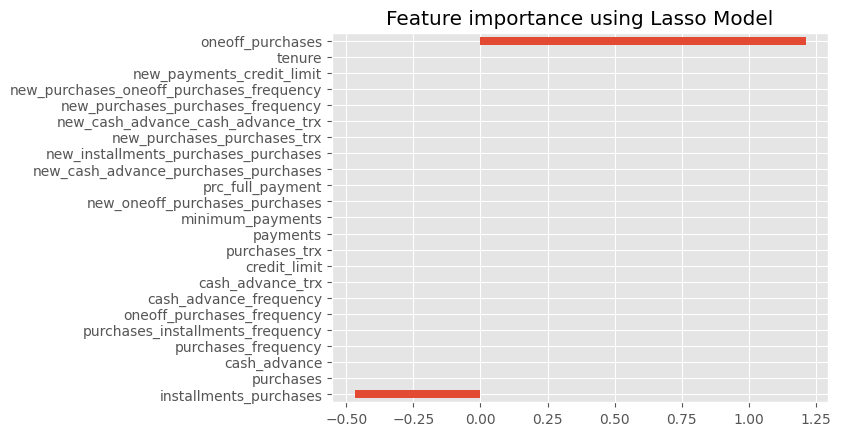

In [74]:
imp_coef = coef.sort_values()
lasso_FE = imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
plt.show()

# Applying Hierarchial Clustering

In [82]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler, VectorAssembler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [81]:
# Load data into Spark DataFrame
raw_df = spark.read.csv("ctzn_customer_segmentation_data.csv", header=True, inferSchema=True)

# Drop 'cif_id' column and handle missing data
raw_df = raw_df.drop('cif_id')

# Fill missing values (forward fill - Spark does not have direct 'ffill', so we use mean for numeric columns)
from pyspark.sql.functions import mean
for column in raw_df.columns:
    if isinstance(raw_df.schema[column].dataType, (IntegerType, FloatType)):
        mean_value = raw_df.select(mean(raw_df[column])).collect()[0][0]
        raw_df = raw_df.fillna({column: mean_value})

# Show the first few rows
raw_df.show(5)


+---------+------------------+-----------------+----------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+---------+------+----------------+----------------+------------+
|schm_type|           balance|balance_frequency| purchases|oneoff_purchases|installments_purchases|cash_advance|purchases_frequency|oneoff_purchases_frequency|purchases_installments_frequency|cash_advance_frequency|cash_advance_trx|purchases_trx| payments|tenure|minimum_payments|prc_full_payment|credit_limit|
+---------+------------------+-----------------+----------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+---------+------+----------------+----------------+------------+
|      CAA|-41754.05000000005|                0|1669954.05|       8

In [84]:
# # Load data into Spark DataFrame
# raw_df = spark.read.csv("new_columns_customer_segmentation.csv", header=True, inferSchema=True)

# # Drop 'cif_id' column and handle missing data
# raw_df = raw_df.drop('cif_id')

# Fill missing values (forward fill - Spark does not have direct 'ffill', so we use mean for numeric columns)
from pyspark.sql.functions import mean
for column in raw_df.columns:
    if isinstance(raw_df.schema[column].dataType, (IntegerType, FloatType)):
        mean_value = raw_df.select(mean(raw_df[column])).collect()[0][0]
        raw_df = raw_df.fillna({column: mean_value})

# Show the first few rows
raw_df.show(5)


+---------+------------------+-----------------+----------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+---------+------+----------------+----------------+------------+
|schm_type|           balance|balance_frequency| purchases|oneoff_purchases|installments_purchases|cash_advance|purchases_frequency|oneoff_purchases_frequency|purchases_installments_frequency|cash_advance_frequency|cash_advance_trx|purchases_trx| payments|tenure|minimum_payments|prc_full_payment|credit_limit|
+---------+------------------+-----------------+----------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+---------+------+----------------+----------------+------------+
|      CAA|-41754.05000000005|                0|1669954.05|       8

In [85]:
# Select numeric columns
numeric_columns = [col for col, dtype in raw_df.dtypes if dtype in ['int', 'double']]

# Prepare the data for scaling and PCA
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
raw_df_assembled = assembler.transform(raw_df)


In [87]:
from pyspark.ml.feature import Normalizer

# Standardize the data
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(raw_df_assembled)
raw_df_scaled = scaler_model.transform(raw_df_assembled)

# Normalize the data (using Spark's built-in normalization approach)
normalizer = Normalizer(inputCol="scaled_features", outputCol="normalized_features")
raw_df_normalized = normalizer.transform(raw_df_scaled)

# Show the first few rows of normalized data
raw_df_normalized.select("normalized_features").show(5)


+--------------------+
| normalized_features|
+--------------------+
|(17,[0,2,3,4,6,9,...|
|     (17,[13],[1.0])|
|     (17,[13],[1.0])|
|     (17,[13],[1.0])|
|     (17,[13],[1.0])|
+--------------------+
only showing top 5 rows



In [88]:
# Apply PCA to reduce dimensions to 2
pca = PCA(k=2, inputCol="normalized_features", outputCol="pca_features")
pca_model = pca.fit(raw_df_normalized)
raw_df_pca = pca_model.transform(raw_df_normalized)

# Show PCA results
raw_df_pca.select("pca_features").show(5)


+--------------------+
|        pca_features|
+--------------------+
|[-0.2467072481187...|
|[0.58059220922368...|
|[0.58059220922368...|
|[0.58059220922368...|
|[0.58059220922368...|
+--------------------+
only showing top 5 rows



# Agglometric Clustering

+--------------------+----------+
|        pca_features|prediction|
+--------------------+----------+
|[-0.2467072481187...|         0|
|[0.58059220922368...|         0|
|[0.58059220922368...|         0|
|[0.58059220922368...|         0|
|[0.58059220922368...|         0|
+--------------------+----------+
only showing top 5 rows



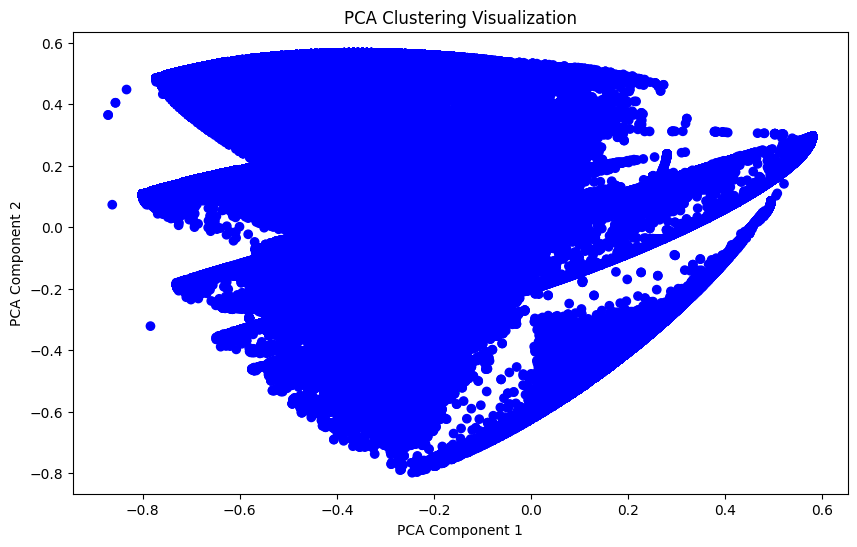

In [89]:
from pyspark.ml.clustering import KMeans

# KMeans clustering for demonstration (using 3 clusters for example)
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(raw_df_pca)
predictions = model.transform(raw_df_pca)

# Show predictions (cluster assignments)
predictions.select("pca_features", "prediction").show(5)

# Visualizing the PCA results with clustering
pca_results = predictions.select("pca_features", "prediction").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(pca_results['pca_features'].apply(lambda x: x[0]), pca_results['pca_features'].apply(lambda x: x[1]), c=pca_results['prediction'], cmap=plt.cm.winter)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Clustering Visualization')
plt.show()


In [90]:
# Silhouette Score (For Evaluating Cluster Performance)

silhouette_scores = [] 

from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering with silhouette score
evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette_score}")


Silhouette Score: 0.9999160611680095


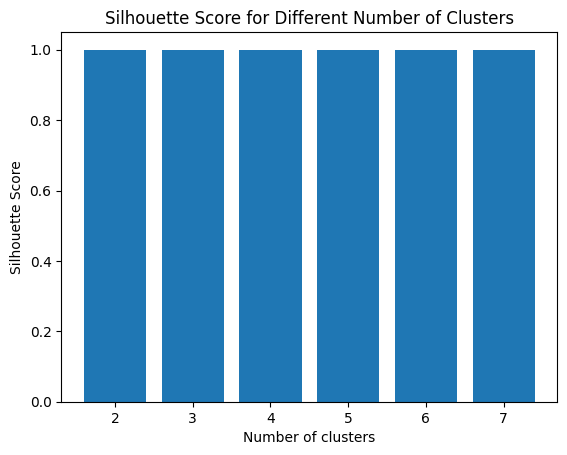

In [91]:
# PCA and KMeans Clustering for Varying Cluster Numbers

silhouette_scores = []
for n_clusters in range(2, 8):
    kmeans = KMeans().setK(n_clusters).setSeed(1)
    model = kmeans.fit(raw_df_pca)
    predictions = model.transform(raw_df_pca)
    
    # Evaluate silhouette score for the current number of clusters
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)

# Plot silhouette scores
plt.bar(range(2, 8), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Number of Clusters')
plt.show()



In [95]:
from pyspark.sql import functions as F

# Step 1: Add a unique row identifier to raw_df
raw_df_with_id = raw_df.withColumn("row_id", F.monotonically_increasing_id())

# Step 2: Perform KMeans clustering
num_clusters = 6
kmeans = KMeans().setK(num_clusters).setSeed(1)
model = kmeans.fit(raw_df_pca)
predictions = model.transform(raw_df_pca)

# Step 3: Add a unique row identifier to predictions
predictions_with_id = predictions.withColumn("row_id", F.monotonically_increasing_id())

# Step 4: Join raw_df with predictions using 'row_id'
final_df = raw_df_with_id.join(predictions_with_id.select("row_id", "prediction"), on="row_id", how="inner")

# Step 5: Show the final DataFrame with clusters
final_df.show(5)


+------+---------+------------------+-----------------+-------------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+-------------+------+----------------+----------------+------------+----------+
|row_id|schm_type|           balance|balance_frequency|    purchases|oneoff_purchases|installments_purchases|cash_advance|purchases_frequency|oneoff_purchases_frequency|purchases_installments_frequency|cash_advance_frequency|cash_advance_trx|purchases_trx|     payments|tenure|minimum_payments|prc_full_payment|credit_limit|prediction|
+------+---------+------------------+-----------------+-------------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+-------------+------+----------------+----------------+------------+----

In [96]:
# Grouping by cluster and calculating summary statistics for numeric columns
cluster_summary = final_df.groupBy("cluster").agg(*[
    F.mean(col).alias(f"mean_{col}") for col in numeric_columns
])

# Show cluster summary statistics
cluster_summary.show()

# Optionally save to CSV
cluster_summary_df = cluster_summary.toPandas()
cluster_summary_df.to_csv('cluster_summary.csv', index=False)


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `cluster` cannot be resolved. Did you mean one of the following? [`balance`, `tenure`, `row_id`, `schm_type`, `payments`].;
'Aggregate ['cluster], ['cluster, avg(balance#12422) AS mean_balance#16572, avg(balance_frequency#13039) AS mean_balance_frequency#16574, avg(purchases#12424) AS mean_purchases#16576, avg(oneoff_purchases#12425) AS mean_oneoff_purchases#16578, avg(installments_purchases#12426) AS mean_installments_purchases#16580, avg(cash_advance#12427) AS mean_cash_advance#16582, avg(purchases_frequency#13088) AS mean_purchases_frequency#16584, avg(oneoff_purchases_frequency#13137) AS mean_oneoff_purchases_frequency#16586, avg(purchases_installments_frequency#13186) AS mean_purchases_installments_frequency#16588, avg(cash_advance_frequency#13235) AS mean_cash_advance_frequency#16590, avg(cash_advance_trx#13284) AS mean_cash_advance_trx#16592, avg(purchases_trx#13333) AS mean_purchases_trx#16594, avg(payments#12434) AS mean_payments#16596, avg(tenure#13382) AS mean_tenure#16598, avg(minimum_payments#12436) AS mean_minimum_payments#16600, avg(prc_full_payment#13431) AS mean_prc_full_payment#16602, avg(credit_limit#12438) AS mean_credit_limit#16604]
+- Project [row_id#16180L, schm_type#12421, balance#12422, balance_frequency#13039, purchases#12424, oneoff_purchases#12425, installments_purchases#12426, cash_advance#12427, purchases_frequency#13088, oneoff_purchases_frequency#13137, purchases_installments_frequency#13186, cash_advance_frequency#13235, cash_advance_trx#13284, purchases_trx#13333, payments#12434, tenure#13382, minimum_payments#12436, prc_full_payment#13431, credit_limit#12438, prediction#16338]
   +- Join Inner, (row_id#16180L = row_id#16365L)
      :- Project [schm_type#12421, balance#12422, balance_frequency#13039, purchases#12424, oneoff_purchases#12425, installments_purchases#12426, cash_advance#12427, purchases_frequency#13088, oneoff_purchases_frequency#13137, purchases_installments_frequency#13186, cash_advance_frequency#13235, cash_advance_trx#13284, purchases_trx#13333, payments#12434, tenure#13382, minimum_payments#12436, prc_full_payment#13431, credit_limit#12438, monotonically_increasing_id() AS row_id#16180L]
      :  +- Project [schm_type#12421, balance#12422, balance_frequency#13039, purchases#12424, oneoff_purchases#12425, installments_purchases#12426, cash_advance#12427, purchases_frequency#13088, oneoff_purchases_frequency#13137, purchases_installments_frequency#13186, cash_advance_frequency#13235, cash_advance_trx#13284, purchases_trx#13333, payments#12434, tenure#13382, minimum_payments#12436, coalesce(prc_full_payment#12899, cast(0.713196492706515 as int)) AS prc_full_payment#13431, credit_limit#12438]
      :     +- Project [schm_type#12421, balance#12422, balance_frequency#13039, purchases#12424, oneoff_purchases#12425, installments_purchases#12426, cash_advance#12427, purchases_frequency#13088, oneoff_purchases_frequency#13137, purchases_installments_frequency#13186, cash_advance_frequency#13235, cash_advance_trx#13284, purchases_trx#13333, payments#12434, coalesce(tenure#12850, cast(40.47182543173634 as int)) AS tenure#13382, minimum_payments#12436, prc_full_payment#12899, credit_limit#12438]
      :        +- Project [schm_type#12421, balance#12422, balance_frequency#13039, purchases#12424, oneoff_purchases#12425, installments_purchases#12426, cash_advance#12427, purchases_frequency#13088, oneoff_purchases_frequency#13137, purchases_installments_frequency#13186, cash_advance_frequency#13235, cash_advance_trx#13284, coalesce(purchases_trx#12801, cast(0.8613010817910595 as int)) AS purchases_trx#13333, payments#12434, tenure#12850, minimum_payments#12436, prc_full_payment#12899, credit_limit#12438]
      :           +- Project [schm_type#12421, balance#12422, balance_frequency#13039, purchases#12424, oneoff_purchases#12425, installments_purchases#12426, cash_advance#12427, purchases_frequency#13088, oneoff_purchases_frequency#13137, purchases_installments_frequency#13186, cash_advance_frequency#13235, coalesce(cash_advance_trx#12752, cast(0.0272549403952522 as int)) AS cash_advance_trx#13284, purchases_trx#12801, payments#12434, tenure#12850, minimum_payments#12436, prc_full_payment#12899, credit_limit#12438]
      :              +- Project [schm_type#12421, balance#12422, balance_frequency#13039, purchases#12424, oneoff_purchases#12425, installments_purchases#12426, cash_advance#12427, purchases_frequency#13088, oneoff_purchases_frequency#13137, purchases_installments_frequency#13186, coalesce(cash_advance_frequency#12703, cast(0.762515813740758 as int)) AS cash_advance_frequency#13235, cash_advance_trx#12752, purchases_trx#12801, payments#12434, tenure#12850, minimum_payments#12436, prc_full_payment#12899, credit_limit#12438]
      :                 +- Project [schm_type#12421, balance#12422, balance_frequency#13039, purchases#12424, oneoff_purchases#12425, installments_purchases#12426, cash_advance#12427, purchases_frequency#13088, oneoff_purchases_frequency#13137, coalesce(purchases_installments_frequency#12654, cast(0.0 as int)) AS purchases_installments_frequency#13186, cash_advance_frequency#12703, cash_advance_trx#12752, purchases_trx#12801, payments#12434, tenure#12850, minimum_payments#12436, prc_full_payment#12899, credit_limit#12438]
      :                    +- Project [schm_type#12421, balance#12422, balance_frequency#13039, purchases#12424, oneoff_purchases#12425, installments_purchases#12426, cash_advance#12427, purchases_frequency#13088, coalesce(oneoff_purchases_frequency#12605, cast(0.009388693130341238 as int)) AS oneoff_purchases_frequency#13137, purchases_installments_frequency#12654, cash_advance_frequency#12703, cash_advance_trx#12752, purchases_trx#12801, payments#12434, tenure#12850, minimum_payments#12436, prc_full_payment#12899, credit_limit#12438]
      :                       +- Project [schm_type#12421, balance#12422, balance_frequency#13039, purchases#12424, oneoff_purchases#12425, installments_purchases#12426, cash_advance#12427, coalesce(purchases_frequency#12556, cast(2.6644353793574282 as int)) AS purchases_frequency#13088, oneoff_purchases_frequency#12605, purchases_installments_frequency#12654, cash_advance_frequency#12703, cash_advance_trx#12752, purchases_trx#12801, payments#12434, tenure#12850, minimum_payments#12436, prc_full_payment#12899, credit_limit#12438]
      :                          +- Project [schm_type#12421, balance#12422, coalesce(balance_frequency#12507, cast(0.0 as int)) AS balance_frequency#13039, purchases#12424, oneoff_purchases#12425, installments_purchases#12426, cash_advance#12427, purchases_frequency#12556, oneoff_purchases_frequency#12605, purchases_installments_frequency#12654, cash_advance_frequency#12703, cash_advance_trx#12752, purchases_trx#12801, payments#12434, tenure#12850, minimum_payments#12436, prc_full_payment#12899, credit_limit#12438]
      :                             +- Project [schm_type#12421, balance#12422, balance_frequency#12507, purchases#12424, oneoff_purchases#12425, installments_purchases#12426, cash_advance#12427, purchases_frequency#12556, oneoff_purchases_frequency#12605, purchases_installments_frequency#12654, cash_advance_frequency#12703, cash_advance_trx#12752, purchases_trx#12801, payments#12434, tenure#12850, minimum_payments#12436, coalesce(prc_full_payment#12437, cast(0.713196492706515 as int)) AS prc_full_payment#12899, credit_limit#12438]
      :                                +- Project [schm_type#12421, balance#12422, balance_frequency#12507, purchases#12424, oneoff_purchases#12425, installments_purchases#12426, cash_advance#12427, purchases_frequency#12556, oneoff_purchases_frequency#12605, purchases_installments_frequency#12654, cash_advance_frequency#12703, cash_advance_trx#12752, purchases_trx#12801, payments#12434, coalesce(tenure#12435, cast(40.47182543173634 as int)) AS tenure#12850, minimum_payments#12436, prc_full_payment#12437, credit_limit#12438]
      :                                   +- Project [schm_type#12421, balance#12422, balance_frequency#12507, purchases#12424, oneoff_purchases#12425, installments_purchases#12426, cash_advance#12427, purchases_frequency#12556, oneoff_purchases_frequency#12605, purchases_installments_frequency#12654, cash_advance_frequency#12703, cash_advance_trx#12752, coalesce(purchases_trx#12433, cast(0.8613010817910595 as int)) AS purchases_trx#12801, payments#12434, tenure#12435, minimum_payments#12436, prc_full_payment#12437, credit_limit#12438]
      :                                      +- Project [schm_type#12421, balance#12422, balance_frequency#12507, purchases#12424, oneoff_purchases#12425, installments_purchases#12426, cash_advance#12427, purchases_frequency#12556, oneoff_purchases_frequency#12605, purchases_installments_frequency#12654, cash_advance_frequency#12703, coalesce(cash_advance_trx#12432, cast(0.0272549403952522 as int)) AS cash_advance_trx#12752, purchases_trx#12433, payments#12434, tenure#12435, minimum_payments#12436, prc_full_payment#12437, credit_limit#12438]
      :                                         +- Project [schm_type#12421, balance#12422, balance_frequency#12507, purchases#12424, oneoff_purchases#12425, installments_purchases#12426, cash_advance#12427, purchases_frequency#12556, oneoff_purchases_frequency#12605, purchases_installments_frequency#12654, coalesce(cash_advance_frequency#12431, cast(0.762515813740758 as int)) AS cash_advance_frequency#12703, cash_advance_trx#12432, purchases_trx#12433, payments#12434, tenure#12435, minimum_payments#12436, prc_full_payment#12437, credit_limit#12438]
      :                                            +- Project [schm_type#12421, balance#12422, balance_frequency#12507, purchases#12424, oneoff_purchases#12425, installments_purchases#12426, cash_advance#12427, purchases_frequency#12556, oneoff_purchases_frequency#12605, coalesce(purchases_installments_frequency#12430, cast(0.0 as int)) AS purchases_installments_frequency#12654, cash_advance_frequency#12431, cash_advance_trx#12432, purchases_trx#12433, payments#12434, tenure#12435, minimum_payments#12436, prc_full_payment#12437, credit_limit#12438]
      :                                               +- Project [schm_type#12421, balance#12422, balance_frequency#12507, purchases#12424, oneoff_purchases#12425, installments_purchases#12426, cash_advance#12427, purchases_frequency#12556, coalesce(oneoff_purchases_frequency#12429, cast(0.009388693130341238 as int)) AS oneoff_purchases_frequency#12605, purchases_installments_frequency#12430, cash_advance_frequency#12431, cash_advance_trx#12432, purchases_trx#12433, payments#12434, tenure#12435, minimum_payments#12436, prc_full_payment#12437, credit_limit#12438]
      :                                                  +- Project [schm_type#12421, balance#12422, balance_frequency#12507, purchases#12424, oneoff_purchases#12425, installments_purchases#12426, cash_advance#12427, coalesce(purchases_frequency#12428, cast(2.6644353793574282 as int)) AS purchases_frequency#12556, oneoff_purchases_frequency#12429, purchases_installments_frequency#12430, cash_advance_frequency#12431, cash_advance_trx#12432, purchases_trx#12433, payments#12434, tenure#12435, minimum_payments#12436, prc_full_payment#12437, credit_limit#12438]
      :                                                     +- Project [schm_type#12421, balance#12422, coalesce(balance_frequency#12423, cast(0.0 as int)) AS balance_frequency#12507, purchases#12424, oneoff_purchases#12425, installments_purchases#12426, cash_advance#12427, purchases_frequency#12428, oneoff_purchases_frequency#12429, purchases_installments_frequency#12430, cash_advance_frequency#12431, cash_advance_trx#12432, purchases_trx#12433, payments#12434, tenure#12435, minimum_payments#12436, prc_full_payment#12437, credit_limit#12438]
      :                                                        +- Project [schm_type#12421, balance#12422, balance_frequency#12423, purchases#12424, oneoff_purchases#12425, installments_purchases#12426, cash_advance#12427, purchases_frequency#12428, oneoff_purchases_frequency#12429, purchases_installments_frequency#12430, cash_advance_frequency#12431, cash_advance_trx#12432, purchases_trx#12433, payments#12434, tenure#12435, minimum_payments#12436, prc_full_payment#12437, credit_limit#12438]
      :                                                           +- Relation [cif_id#12420,schm_type#12421,balance#12422,balance_frequency#12423,purchases#12424,oneoff_purchases#12425,installments_purchases#12426,cash_advance#12427,purchases_frequency#12428,oneoff_purchases_frequency#12429,purchases_installments_frequency#12430,cash_advance_frequency#12431,cash_advance_trx#12432,purchases_trx#12433,payments#12434,tenure#12435,minimum_payments#12436,prc_full_payment#12437,credit_limit#12438] csv
      +- Project [row_id#16365L, prediction#16338]
         +- Project [schm_type#16393, balance#16394, balance_frequency#13039, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#13088, oneoff_purchases_frequency#13137, purchases_installments_frequency#13186, cash_advance_frequency#13235, cash_advance_trx#13284, purchases_trx#13333, payments#16406, tenure#13382, minimum_payments#16408, prc_full_payment#13431, credit_limit#16410, features#13551, scaled_features#13695, normalized_features#13722, pca_features#13792, prediction#16338, monotonically_increasing_id() AS row_id#16365L]
            +- Project [schm_type#16393, balance#16394, balance_frequency#13039, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#13088, oneoff_purchases_frequency#13137, purchases_installments_frequency#13186, cash_advance_frequency#13235, cash_advance_trx#13284, purchases_trx#13333, payments#16406, tenure#13382, minimum_payments#16408, prc_full_payment#13431, credit_limit#16410, features#13551, scaled_features#13695, normalized_features#13722, pca_features#13792, UDF(features#13551) AS prediction#16338]
               +- Project [schm_type#16393, balance#16394, balance_frequency#13039, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#13088, oneoff_purchases_frequency#13137, purchases_installments_frequency#13186, cash_advance_frequency#13235, cash_advance_trx#13284, purchases_trx#13333, payments#16406, tenure#13382, minimum_payments#16408, prc_full_payment#13431, credit_limit#16410, features#13551, scaled_features#13695, normalized_features#13722, UDF(normalized_features#13722) AS pca_features#13792]
                  +- Project [schm_type#16393, balance#16394, balance_frequency#13039, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#13088, oneoff_purchases_frequency#13137, purchases_installments_frequency#13186, cash_advance_frequency#13235, cash_advance_trx#13284, purchases_trx#13333, payments#16406, tenure#13382, minimum_payments#16408, prc_full_payment#13431, credit_limit#16410, features#13551, scaled_features#13695, UDF(scaled_features#13695) AS normalized_features#13722]
                     +- Project [schm_type#16393, balance#16394, balance_frequency#13039, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#13088, oneoff_purchases_frequency#13137, purchases_installments_frequency#13186, cash_advance_frequency#13235, cash_advance_trx#13284, purchases_trx#13333, payments#16406, tenure#13382, minimum_payments#16408, prc_full_payment#13431, credit_limit#16410, features#13551, UDF(features#13551) AS scaled_features#13695]
                        +- Project [schm_type#16393, balance#16394, balance_frequency#13039, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#13088, oneoff_purchases_frequency#13137, purchases_installments_frequency#13186, cash_advance_frequency#13235, cash_advance_trx#13284, purchases_trx#13333, payments#16406, tenure#13382, minimum_payments#16408, prc_full_payment#13431, credit_limit#16410, UDF(struct(balance, balance#16394, balance_frequency_double_VectorAssembler_50a218817765, cast(balance_frequency#13039 as double), purchases, purchases#16396, oneoff_purchases, oneoff_purchases#16397, installments_purchases, installments_purchases#16398, cash_advance, cash_advance#16399, purchases_frequency_double_VectorAssembler_50a218817765, cast(purchases_frequency#13088 as double), oneoff_purchases_frequency_double_VectorAssembler_50a218817765, cast(oneoff_purchases_frequency#13137 as double), purchases_installments_frequency_double_VectorAssembler_50a218817765, cast(purchases_installments_frequency#13186 as double), cash_advance_frequency_double_VectorAssembler_50a218817765, cast(cash_advance_frequency#13235 as double), cash_advance_trx_double_VectorAssembler_50a218817765, cast(cash_advance_trx#13284 as double), purchases_trx_double_VectorAssembler_50a218817765, cast(purchases_trx#13333 as double), ... 10 more fields)) AS features#13551]
                           +- Project [schm_type#16393, balance#16394, balance_frequency#13039, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#13088, oneoff_purchases_frequency#13137, purchases_installments_frequency#13186, cash_advance_frequency#13235, cash_advance_trx#13284, purchases_trx#13333, payments#16406, tenure#13382, minimum_payments#16408, coalesce(prc_full_payment#12899, cast(0.713196492706515 as int)) AS prc_full_payment#13431, credit_limit#16410]
                              +- Project [schm_type#16393, balance#16394, balance_frequency#13039, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#13088, oneoff_purchases_frequency#13137, purchases_installments_frequency#13186, cash_advance_frequency#13235, cash_advance_trx#13284, purchases_trx#13333, payments#16406, coalesce(tenure#12850, cast(40.47182543173634 as int)) AS tenure#13382, minimum_payments#16408, prc_full_payment#12899, credit_limit#16410]
                                 +- Project [schm_type#16393, balance#16394, balance_frequency#13039, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#13088, oneoff_purchases_frequency#13137, purchases_installments_frequency#13186, cash_advance_frequency#13235, cash_advance_trx#13284, coalesce(purchases_trx#12801, cast(0.8613010817910595 as int)) AS purchases_trx#13333, payments#16406, tenure#12850, minimum_payments#16408, prc_full_payment#12899, credit_limit#16410]
                                    +- Project [schm_type#16393, balance#16394, balance_frequency#13039, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#13088, oneoff_purchases_frequency#13137, purchases_installments_frequency#13186, cash_advance_frequency#13235, coalesce(cash_advance_trx#12752, cast(0.0272549403952522 as int)) AS cash_advance_trx#13284, purchases_trx#12801, payments#16406, tenure#12850, minimum_payments#16408, prc_full_payment#12899, credit_limit#16410]
                                       +- Project [schm_type#16393, balance#16394, balance_frequency#13039, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#13088, oneoff_purchases_frequency#13137, purchases_installments_frequency#13186, coalesce(cash_advance_frequency#12703, cast(0.762515813740758 as int)) AS cash_advance_frequency#13235, cash_advance_trx#12752, purchases_trx#12801, payments#16406, tenure#12850, minimum_payments#16408, prc_full_payment#12899, credit_limit#16410]
                                          +- Project [schm_type#16393, balance#16394, balance_frequency#13039, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#13088, oneoff_purchases_frequency#13137, coalesce(purchases_installments_frequency#12654, cast(0.0 as int)) AS purchases_installments_frequency#13186, cash_advance_frequency#12703, cash_advance_trx#12752, purchases_trx#12801, payments#16406, tenure#12850, minimum_payments#16408, prc_full_payment#12899, credit_limit#16410]
                                             +- Project [schm_type#16393, balance#16394, balance_frequency#13039, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#13088, coalesce(oneoff_purchases_frequency#12605, cast(0.009388693130341238 as int)) AS oneoff_purchases_frequency#13137, purchases_installments_frequency#12654, cash_advance_frequency#12703, cash_advance_trx#12752, purchases_trx#12801, payments#16406, tenure#12850, minimum_payments#16408, prc_full_payment#12899, credit_limit#16410]
                                                +- Project [schm_type#16393, balance#16394, balance_frequency#13039, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, coalesce(purchases_frequency#12556, cast(2.6644353793574282 as int)) AS purchases_frequency#13088, oneoff_purchases_frequency#12605, purchases_installments_frequency#12654, cash_advance_frequency#12703, cash_advance_trx#12752, purchases_trx#12801, payments#16406, tenure#12850, minimum_payments#16408, prc_full_payment#12899, credit_limit#16410]
                                                   +- Project [schm_type#16393, balance#16394, coalesce(balance_frequency#12507, cast(0.0 as int)) AS balance_frequency#13039, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#12556, oneoff_purchases_frequency#12605, purchases_installments_frequency#12654, cash_advance_frequency#12703, cash_advance_trx#12752, purchases_trx#12801, payments#16406, tenure#12850, minimum_payments#16408, prc_full_payment#12899, credit_limit#16410]
                                                      +- Project [schm_type#16393, balance#16394, balance_frequency#12507, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#12556, oneoff_purchases_frequency#12605, purchases_installments_frequency#12654, cash_advance_frequency#12703, cash_advance_trx#12752, purchases_trx#12801, payments#16406, tenure#12850, minimum_payments#16408, coalesce(prc_full_payment#16409, cast(0.713196492706515 as int)) AS prc_full_payment#12899, credit_limit#16410]
                                                         +- Project [schm_type#16393, balance#16394, balance_frequency#12507, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#12556, oneoff_purchases_frequency#12605, purchases_installments_frequency#12654, cash_advance_frequency#12703, cash_advance_trx#12752, purchases_trx#12801, payments#16406, coalesce(tenure#16407, cast(40.47182543173634 as int)) AS tenure#12850, minimum_payments#16408, prc_full_payment#16409, credit_limit#16410]
                                                            +- Project [schm_type#16393, balance#16394, balance_frequency#12507, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#12556, oneoff_purchases_frequency#12605, purchases_installments_frequency#12654, cash_advance_frequency#12703, cash_advance_trx#12752, coalesce(purchases_trx#16405, cast(0.8613010817910595 as int)) AS purchases_trx#12801, payments#16406, tenure#16407, minimum_payments#16408, prc_full_payment#16409, credit_limit#16410]
                                                               +- Project [schm_type#16393, balance#16394, balance_frequency#12507, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#12556, oneoff_purchases_frequency#12605, purchases_installments_frequency#12654, cash_advance_frequency#12703, coalesce(cash_advance_trx#16404, cast(0.0272549403952522 as int)) AS cash_advance_trx#12752, purchases_trx#16405, payments#16406, tenure#16407, minimum_payments#16408, prc_full_payment#16409, credit_limit#16410]
                                                                  +- Project [schm_type#16393, balance#16394, balance_frequency#12507, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#12556, oneoff_purchases_frequency#12605, purchases_installments_frequency#12654, coalesce(cash_advance_frequency#16403, cast(0.762515813740758 as int)) AS cash_advance_frequency#12703, cash_advance_trx#16404, purchases_trx#16405, payments#16406, tenure#16407, minimum_payments#16408, prc_full_payment#16409, credit_limit#16410]
                                                                     +- Project [schm_type#16393, balance#16394, balance_frequency#12507, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#12556, oneoff_purchases_frequency#12605, coalesce(purchases_installments_frequency#16402, cast(0.0 as int)) AS purchases_installments_frequency#12654, cash_advance_frequency#16403, cash_advance_trx#16404, purchases_trx#16405, payments#16406, tenure#16407, minimum_payments#16408, prc_full_payment#16409, credit_limit#16410]
                                                                        +- Project [schm_type#16393, balance#16394, balance_frequency#12507, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#12556, coalesce(oneoff_purchases_frequency#16401, cast(0.009388693130341238 as int)) AS oneoff_purchases_frequency#12605, purchases_installments_frequency#16402, cash_advance_frequency#16403, cash_advance_trx#16404, purchases_trx#16405, payments#16406, tenure#16407, minimum_payments#16408, prc_full_payment#16409, credit_limit#16410]
                                                                           +- Project [schm_type#16393, balance#16394, balance_frequency#12507, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, coalesce(purchases_frequency#16400, cast(2.6644353793574282 as int)) AS purchases_frequency#12556, oneoff_purchases_frequency#16401, purchases_installments_frequency#16402, cash_advance_frequency#16403, cash_advance_trx#16404, purchases_trx#16405, payments#16406, tenure#16407, minimum_payments#16408, prc_full_payment#16409, credit_limit#16410]
                                                                              +- Project [schm_type#16393, balance#16394, coalesce(balance_frequency#16395, cast(0.0 as int)) AS balance_frequency#12507, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#16400, oneoff_purchases_frequency#16401, purchases_installments_frequency#16402, cash_advance_frequency#16403, cash_advance_trx#16404, purchases_trx#16405, payments#16406, tenure#16407, minimum_payments#16408, prc_full_payment#16409, credit_limit#16410]
                                                                                 +- Project [schm_type#16393, balance#16394, balance_frequency#16395, purchases#16396, oneoff_purchases#16397, installments_purchases#16398, cash_advance#16399, purchases_frequency#16400, oneoff_purchases_frequency#16401, purchases_installments_frequency#16402, cash_advance_frequency#16403, cash_advance_trx#16404, purchases_trx#16405, payments#16406, tenure#16407, minimum_payments#16408, prc_full_payment#16409, credit_limit#16410]
                                                                                    +- Relation [cif_id#16392,schm_type#16393,balance#16394,balance_frequency#16395,purchases#16396,oneoff_purchases#16397,installments_purchases#16398,cash_advance#16399,purchases_frequency#16400,oneoff_purchases_frequency#16401,purchases_installments_frequency#16402,cash_advance_frequency#16403,cash_advance_trx#16404,purchases_trx#16405,payments#16406,tenure#16407,minimum_payments#16408,prc_full_payment#16409,credit_limit#16410] csv


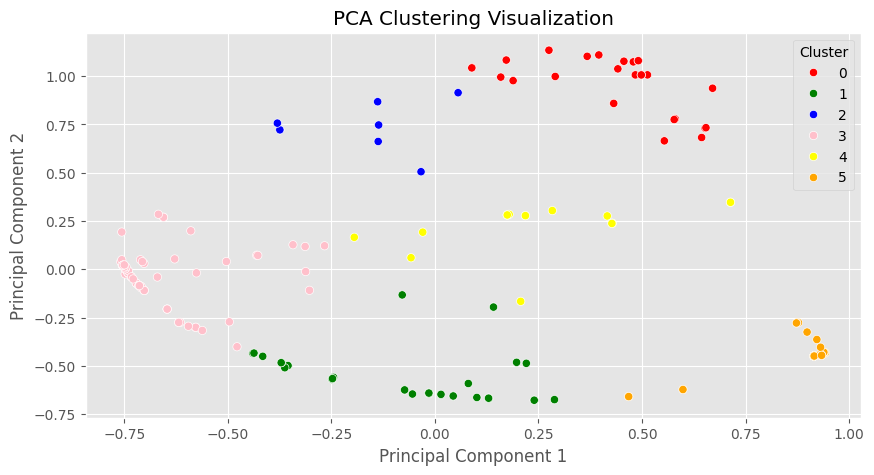

In [95]:
plt.figure(figsize=(10,5))  # Adjust figure size

# Ensure the correct column names are used
pca_df.columns = ['P1', 'P2', 'cluster']  # Rename PCA columns if needed

# Scatter plot
ax = sns.scatterplot(x="P1", y="P2", hue="cluster", data=pca_df, palette=['red', 'green', 'blue', 'pink', 'yellow', 'orange'])

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Clustering Visualization")
plt.legend(title="Cluster")
plt.show()